In [15]:
import scanpy as sc
import matplotlib.pyplot as plt

# Load data

In [85]:
folder_path = "C:/Users/heung/OneDrive/Documents/scData/14. GSE136001_RAW/"
adata = sc.read(folder_path + "annotated.h5ad")
adata

AnnData object with n_obs × n_vars = 37255 × 16739
    obs: 'sample', 'sex', 'condition', 'n_genes', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels', 'leiden', '_scvi_raw_norm_scaling', 'cell_type'
    var: 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'condition_colors', 'dendrogram_cell_type', 'leiden', 'leiden_colors', 'log1p', 'markers', 'neighbors', 'pca', 'rank_genes_groups', 'sample_colors', 'scvi_markers', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    varm: 'PCs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

# DE Analysis by Wilcoxon rank-sum test

In [170]:
# DEG analysis by Wilcoxon rank-sum test
# 한 30초 걸리는듯
i_group = 'Activated microglia' # 여기 적힌 그룹을 아래 reference와 비교.
reference = 'Microglia'         # default = 'rest', 나머지 모든 그룹과 비교

sc.tl.rank_genes_groups(
    adata,
    groupby = 'cell_type',
    groups = [i_group],
    reference = reference,
    method='wilcoxon'
)

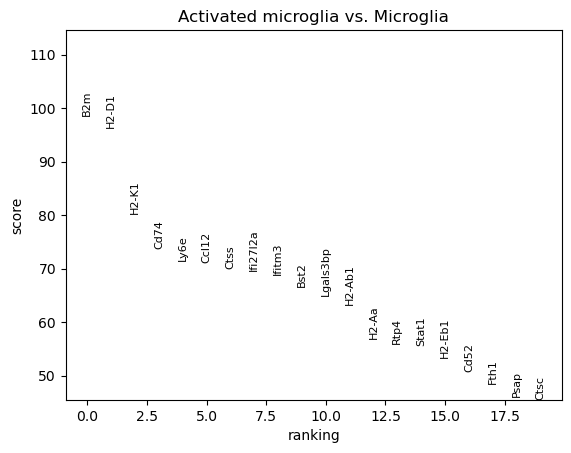

In [177]:
# Plotting
sc.pl.rank_genes_groups(
    adata,
    groups = [i_group],
    n_genes = 20,
    # sharey = False  # 여러 그래프를 한번에 보여줄 때, y축을 공유할지 말지 (True하면 y 축 값이 통일됨)
)

categories: Activated microglia, B cells, BAM, etc.
var_group_labels: Activated microglia


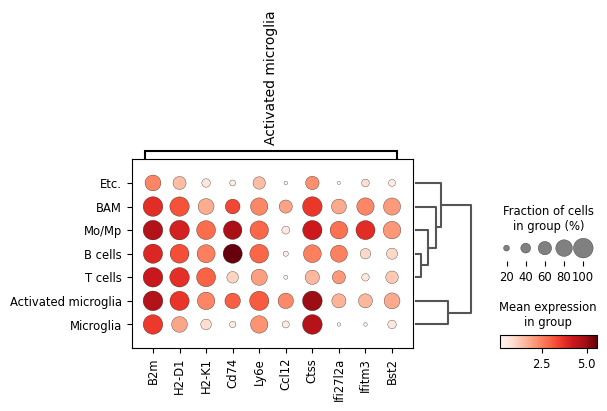

In [90]:
sc.pl.rank_genes_groups_dotplot(
    adata,
    groups = [i_group],
)

categories: Activated microglia, B cells, BAM, etc.
var_group_labels: Activated microglia


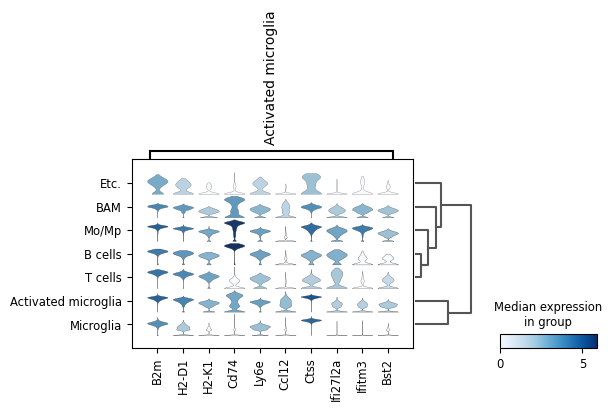

In [91]:
sc.pl.rank_genes_groups_stacked_violin(
    adata,
    groups = [i_group],
)

c:\Users\heung\anaconda3\Lib\site-packages\scanpy\plotting\_tools\__init__.py:1303: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


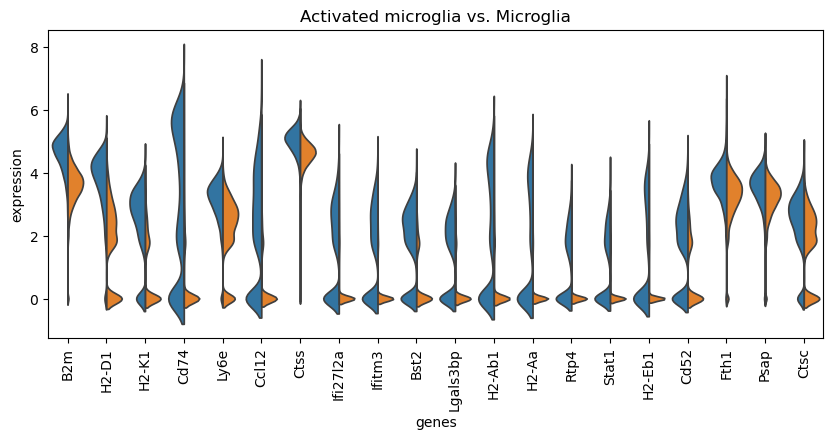

In [179]:
fig, ax = plt.subplots(figsize = (10, 4))
sc.pl.rank_genes_groups_violin(
    adata,
    groups = [i_group],
    size = 0,
    # split = False,
    ax = ax,
    show = False,
)

plt.show()

categories: Activated microglia, B cells, BAM, etc.
var_group_labels: Activated microglia


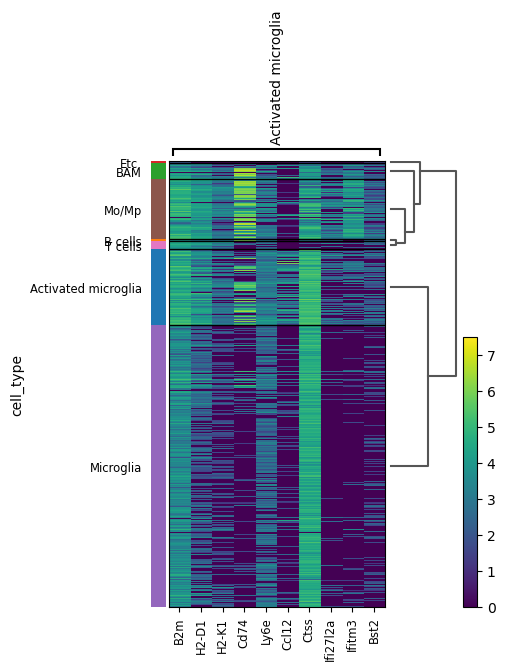

In [93]:

sc.pl.rank_genes_groups_heatmap(
    adata,
    groups = [i_group],

)


# Volcano plot

In [139]:
import pandas as pd
import numpy as np
import seaborn as sns
from adjustText import adjust_text

In [187]:
# Get the DEG results
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
deg_df = pd.DataFrame({
    group + '_' + key: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges', 'pvals', 'pvals_adj', 'scores']
})

# column 이름 변경
deg_df.columns = [col[len(i_group)+1:] for col in deg_df.columns]

# p-value를 -log10 변환
deg_df['nlog10'] = -np.log10(deg_df['pvals_adj'])

# p_value가 너무 낮아 0이면 nlog10이 inf가 되어버리기 때문에 500으로 대체하여 그래프에 표시.
deg_df['nlog10'] = deg_df['nlog10'].replace(np.inf, 500)    #'nlog10'의 값이 'inf'인 경우 500으로 대체
# deg_df['nlog10'] = deg_df.apply(lambda row: 350 + abs(row['logfoldchanges']*10) if row['nlog10'] == 350 else row['nlog10'], axis=1)
deg_df.head()

c:\Users\heung\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,names,logfoldchanges,pvals,pvals_adj,scores,nlog10
0,B2m,1.539792,0.0,0.0,98.654900,500.0
1,H2-D1,2.839691,0.0,0.0,96.418518,500.0
2,H2-K1,2.774177,0.0,0.0,80.336700,500.0
3,Cd74,4.848444,0.0,0.0,73.688606,500.0
4,Ly6e,1.416529,0.0,0.0,71.413391,500.0


In [188]:
# logfoldchange의 절대값이 10 이상이면서 p-vals_adj가 0.05 이상인 행을 없앰
deg_df = deg_df[~((deg_df['logfoldchanges'].abs() > 10) & (deg_df['nlog10'] < 2))]

In [189]:
# 점 색상 설정
filtered_gene_list = []
def map_color(a):
    log2FC, gene, nlog10 = a
    
    if abs(log2FC) < 1 or nlog10 < 2:   # nlog10 < 2 : p-value가 0.01 이상인 경우 -> 유의미하지 않음
        return 'not_cares'
    if gene in filtered_gene_list:
        return 'gene_of_interest'
    
    return 'i_care'

deg_df['color'] = deg_df[['logfoldchanges', 'names', 'nlog10']].apply(map_color, axis = 1)
deg_df.head()

,names,logfoldchanges,pvals,pvals_adj,scores,nlog10,color
0,B2m,1.539792,0.0,0.0,98.654900,500.0,i_care
1,H2-D1,2.839691,0.0,0.0,96.418518,500.0,i_care
2,H2-K1,2.774177,0.0,0.0,80.336700,500.0,i_care
3,Cd74,4.848444,0.0,0.0,73.688606,500.0,i_care
4,Ly6e,1.416529,0.0,0.0,71.413391,500.0,i_care


In [190]:
# i_care 유전자 이름 모두 추출
name_list = deg_df.loc[deg_df['color'] == 'i_care', 'names'].tolist()

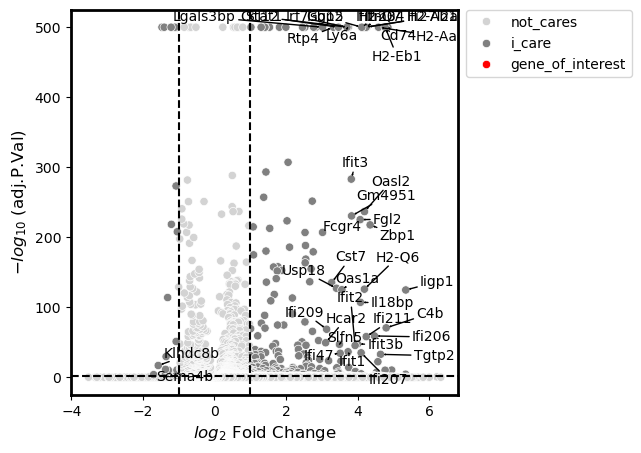

In [192]:
# volcano plot
plt.figure(figsize=(5, 5))

ax = sns.scatterplot(
    data = deg_df,
    x = 'logfoldchanges',
    y = 'nlog10',
    hue = 'color',
    hue_order = ['not_cares', 'i_care', 'gene_of_interest'],
    palette = ['lightgrey', 'grey', 'red'],
    # size = 'scores',
    # sizes = (1, 100),
)

# 축 설정===============================================================
ax.axhline(2, zorder = 1, c = 'k', lw = 1.5, ls = '--')
ax.axvline(1, zorder = 1, c = 'k', lw = 1.5, ls = '--')
ax.axvline(-1, zorder = 1, c = 'k', lw = 1.5, ls = '--')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

plt.xlabel('$log_2$ Fold Change', size = 12)
plt.ylabel("$-log_{10}$ (adj.P.Val)", size = 12)


# 원하는 gene name 표시===============================================================
# name_list에 있는 gene 표시
# 원하는 유전자만 표시하고 싶으면 위의 filtered_gene_list에 유전자 이름 추가한 후
# 아래의 name_list 를 filtered_gene_list로 바꾸고 조건문 적당히 수정하고 실행
texts = []
for i in range(len(deg_df)):
    if deg_df.iloc[i].names in name_list and abs(deg_df.iloc[i].logfoldchanges) > 3 and deg_df.iloc[i].nlog10 > 30:
        texts.append(plt.text(x = deg_df.iloc[i].logfoldchanges, y = deg_df.iloc[i].nlog10, s = deg_df.iloc[i].names))
    if deg_df.iloc[i].names in name_list and deg_df.iloc[i].logfoldchanges < -1.5:# and deg_df.iloc[i].nlog10 > 30:
        texts.append(plt.text(x = deg_df.iloc[i].logfoldchanges, y = deg_df.iloc[i].nlog10, s = deg_df.iloc[i].names))

adjust_text(texts, arrowprops = dict(arrowstyle = '->', color = 'k'))


legend = ax.get_legend()
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad = 0)